### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [685]:
# Imports
# pip install imageio matplotlib scikit-learn
import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [686]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


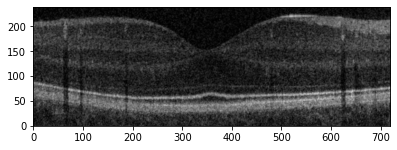

In [687]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [688]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


In [689]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [690]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [691]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

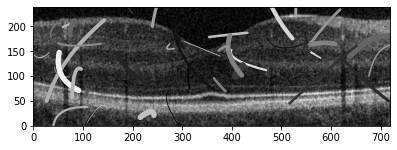

In [692]:
# Initialise clew of 40 and draw

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

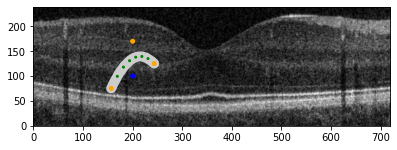

In [693]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

In [694]:
import numpy as np

class CostFunction:
    def __init__(self, image, weights):
        self.image = image
        self.weights = weights

    def coverage_cost(self, worm):
        pass

    def smoothness_cost(self, worm):
        pass

    def detail_preservation_cost(self, worm):
        pass

    def color_adaptation_cost(self, worm):
        total_color_cost = 0

        # Get all points along the worm's path
        path = worm.intermediate_points(8)
        print(path)

        # Calculate color adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))

            # Calculate color difference between worm and image at each point
            worm_color = worm.colour
            image_color = self.image[y, x].astype(float) / 255
            color_difference = np.linalg.norm(worm_color - image_color)
            print("colour: ", worm_color, image_color, color_difference, " - points:",x, y)

            # Accumulate color adaptation cost
            total_color_cost += color_difference

        return total_color_cost

    def efficiency_cost(self, worm):
        pass

    def evaluate(self, worm):
        # Evaluate the total cost
        coverage_cost = 0 #self.coverage_cost(worm)
        smoothness_cost = 0 #self.smoothness_cost(worm)
        detail_cost = 0 #self.detail_preservation_cost(worm)
        color_cost = self.color_adaptation_cost(worm)
        efficiency_cost = 0 #self.efficiency_cost(worm)

        total_cost = (self.weights['coverage'] * coverage_cost +
                      self.weights['smoothness'] * smoothness_cost +
                      self.weights['detail'] * detail_cost +
                      self.weights['color'] * color_cost +
                      self.weights['efficiency'] * efficiency_cost)

        return total_cost

In [695]:
import random

class GeneticAlgorithm:
    def __init__(self, image, population_size, mutation_rate, weights):
        self.image = image
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.weights = weights

    def initialise_population(self, image_shape, init_params):
        population = [random_worm(image_shape, init_params) for _ in range(self.population_size)]
        return population

    def select_parents(self, population):
        # Select parents based on fitness
        tournament_size = 3
        parents = []
        for _ in range(self.population_size):
            # ------------ Replace with Different Function------------
            tournament_indices = np.random.choice(range(len(population)), tournament_size, replace=False)
            tournament = [population[i] for i in tournament_indices]
            winner = random.choice(tournament)
            parents.append(winner)
        return parents

    def crossover(self, parent1, parent2):
        # Perform single-point crossover
        p1, p2 = parent1.control_points(), parent2.control_points()
        crossover_p = np.random.randint(1, len(parent1.control_points()) - 1)
        
        # ------- Crossover points needs work ------------
        c1_cp = np.concatenate((p1[:crossover_p], p2[crossover_p:]))
        c2_cp = np.concatenate((p2[:crossover_p], p1[crossover_p:]))

        # Get other parameters from parents
        r1, r2 = parent1.r, parent2.r
        theta1, theta2 = parent1.theta, parent2.theta
        deviation_r = parent1.dr if np.random.choice([True, False]) else parent2.dr
        deviation_gamma = parent1.dgamma if np.random.choice([True, False]) else parent2.dgamma
        width = parent1.width if np.random.choice([True, False]) else parent2.width
        colour = parent1.colour if np.random.choice([True, False]) else parent2.colour
        
        child1 = Camo_Worm(parent1.x, parent2.y, r1, theta1, deviation_r, deviation_gamma, width, colour)
        child2 = Camo_Worm(parent2.x, parent2.y, r2, theta2, deviation_r, deviation_gamma, width, colour)
        # child1.bezier = mbezier.BezierSegment(c1_cp)
        # child2.bezier = mbezier.BezierSegment(c2_cp)
        return child1, child2

    def mutate(self, worm):
        # Mutate offspring
        # Randomly select one parameter of the worm and mutate it
        pass

    def run(self, max_generations, init_params):
        # Initialize population
        population = self.initialise_population(self.image.shape, init_params)

         # ------------ Add Cost_function to offspring------------
        for generation in range(max_generations):
            # Select parents
            parents = self.select_parents(population)

            # Create offspring through crossover
            offspring = []
            for i in range(0, self.population_size, 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                offspring.extend([child1, child2])

            # Replace old population with new population
            population = offspring

            # Mutate offspring
            for mutant in population:
                if np.random.rand() < self.mutation_rate:
                    self.mutate(mutant)


        return population

(array([ 56.69872981, 155.        ]), array([ 69.07052129, 179.28571429]), array([ 81.44231278, 197.85714286]), array([ 93.81410426, 210.71428571]), array([106.18589574, 217.85714286]), array([118.55768722, 219.28571429]), array([130.92947871, 215.        ]), array([143.30127019, 205.        ]))
colour:  0.4 0.2196078431372549 0.18039215686274512  - points: 56 155
colour:  0.4 0.20392156862745098 0.19607843137254904  - points: 69 179
colour:  0.4 0.10588235294117647 0.29411764705882354  - points: 81 197
colour:  0.4 0.3568627450980392 0.0431372549019608  - points: 93 210
colour:  0.4 0.16862745098039217 0.23137254901960785  - points: 106 217
colour:  0.4 0.058823529411764705 0.3411764705882353  - points: 118 219
colour:  0.4 0.32941176470588235 0.07058823529411767  - points: 130 215
colour:  0.4 0.20784313725490197 0.19215686274509805  - points: 143 205
1.5490196078431375


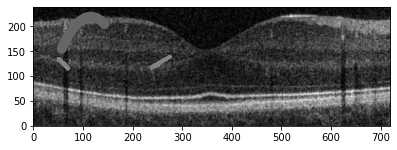

In [705]:
# Define parameters for the Genetic Algorithm
population_size = 10
mutation_rate = 0.1
# Define weights --- to be adjusted/required?
weights = {'coverage': 1, 'smoothness': 1, 'detail': 1, 'color': 1, 'efficiency': 1}

# Create an instance of the GeneticAlgorithm class
genetic_algorithm = GeneticAlgorithm(image, population_size, mutation_rate, weights)

# Define initial parameters for the worms
init_params = (40, 30, 1)  # Example parameters, adjust as needed

# Define the maximum number of generations
max_generations = 10
clew = genetic_algorithm.run(max_generations, init_params)

# Display the optimized population of worms
drawing = Drawing(image)
for worm in clew:
    drawing.add_worms(worm)

worm_test = Camo_Worm(100, 180, 50, np.pi/6, 70, np.pi/3, 10, 0.4)
cost = CostFunction(image, weights)
c_c = cost.evaluate(worm_test)
print(c_c)
drawing.add_worms(worm_test)

drawing.show()


&copy; Cara MacNish, UWA, 2024